In [1]:
from scripts.classification_functions import *
from scripts.helper_functions import *
from scripts.feature_importance import *
from scripts.evaluation_classifier import Evaluater

from itertools import product, combinations

### Extract relevant FS (FreeSurfer), ID and covariate columns from templates

In [3]:
OUTPUT_DIR = '/data/wbbruin/Documents/Stage-Machine-Learning/ENIGMA_PANIC/POOLED/'
ORGANISED_DATA_DIR = '/data/wbbruin/Documents/Stage-Machine-Learning/ENIGMA_PANIC/ORGANISED/'
SPREADSHEET_TEMPLATES_DIR = '/data/wbbruin/Documents/Stage-Machine-Learning/ENIGMA_PANIC/Templates/'

FS_cols, FS_cols_wo_global = extract_FS_cols(SPREADSHEET_TEMPLATES_DIR)

# These are the columns related to indexing
id_cols = ['WG', 'SubjID', 'MultiSiteID', 'SubjID_og', 'MultiSiteID_og']

# For ML analyses, we will extract following demographical and clinical info
demo_and_clinical_cols = ['Dx', 'Sex', 'Age',
                          'Med', 'SSRI_SNRI', 'Benzo', 'Apsy', 'OtherMed', # Medication info
                          'ComANXD', 'SAD', 'PD', 'AG', 'GAD', 'SPH', 'OtherANXD', # ANXD comorbidity info
                          'MDD', 'OCD', 'PTSD', 'SUD', 'OtherD', # Non-ANXD comorbidity info
                          'AgeO',
                          'STAI_T', 'BAI', 'BDI_II']

# Merge all columns of interest
pooled_columns = np.concatenate([id_cols, demo_and_clinical_cols, FS_cols])

Total FS columns: 157
Total FS columns without global hemishpere measures and ICV: 152


### Load CSV containing data into pandas dataframe

In [4]:
SAVE_DIR = '/data/wbbruin/Desktop/ENIGMA_ANXIETY/cross_disorder_data/'

# This dataset contains duplicates of subjects that were included across multiple workoing groups (i.e. PD/SAD/GAD)
pooled_df = pd.read_csv(os.path.join(SAVE_DIR, 'pooled_cross_disorder_data.csv'))

# Here duplicates have been removed already. This dataset will be used for cross-disorder classifications
pooled_df_no_duplicates = pd.read_csv(os.path.join(SAVE_DIR, 'pooled_cross_disorder_data_no_duplicates.csv'))

pooled_df.shape, pooled_df_no_duplicates.shape

((4076, 190), (3508, 190))

In [5]:
# Apply age filter for adolescence: min = 10, max = 25 y/o

min_age, max_age = 10, 25

pooled_df = pooled_df.loc[(pooled_df.Age >= min_age) & (pooled_df.Age <= max_age)]

pooled_df_no_duplicates = pooled_df_no_duplicates.loc[(pooled_df_no_duplicates.Age >= min_age) & 
                                                      (pooled_df_no_duplicates.Age <= max_age)]

print(pooled_df.Age.min(), pooled_df.Age.max()) # Age range after filtering
pooled_df.shape, pooled_df_no_duplicates.shape

10.0 25.0


((3773, 190), (3211, 190))

### Exclude subjects that have too many (>25%) missing features 

In [6]:
# Exclude subjects with too many missing features for pooled data across WG
pooled_df = exclude_subjects_with_missing_features(pooled_df, FS_cols_wo_global)

# Do the same for cross-disorder data without duplicate entries
pooled_df_no_duplicates = exclude_subjects_with_missing_features(pooled_df_no_duplicates, FS_cols_wo_global)

pooled_df.shape, pooled_df_no_duplicates.shape

1351 of 3773 subjects have >=1 missing features
17 subjects excluded with >25% missing features
WG   Dx 
PD   0.0    13
     1.0     3
SAD  0.0     1
dtype: int64

1050 of 3211 subjects have >=1 missing features
16 subjects excluded with >25% missing features
WG  Dx 
PD  0.0    13
    1.0     3
dtype: int64



((3756, 190), (3195, 190))

### Parse the median of STAI scores (severity) of patients

median STAI_T : 48.0
Patients with valid STAI_T scores: 1782, 319 low severity and 321 high severity


<AxesSubplot:>

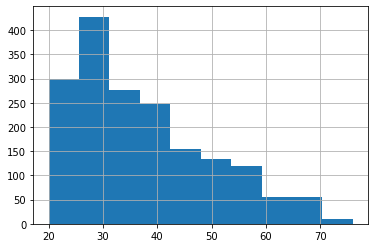

In [7]:
# This is the valid range according to covariates description file: (20-80). Create new column for filtered STAI_T
pooled_df_no_duplicates['STAI_T_filtered'] = pooled_df_no_duplicates['STAI_T']

# Apply valid range (fill NaNs for those values that fall outside range)
pooled_df_no_duplicates.loc[(pooled_df_no_duplicates.STAI_T_filtered < 20), 'STAI_T_filtered'] = np.NaN
pooled_df_no_duplicates.loc[(pooled_df_no_duplicates.STAI_T_filtered > 80), 'STAI_T_filtered'] = np.NaN


# Also filter STAI_T scores for full pooled data across WG (contains duplicates)
pooled_df['STAI_T_filtered'] = pooled_df['STAI_T']

# Apply valid range (fill NaNs for those values that fall outside range)
pooled_df.loc[(pooled_df.STAI_T_filtered < 20), 'STAI_T_filtered'] = np.NaN
pooled_df.loc[(pooled_df.STAI_T_filtered > 80), 'STAI_T_filtered'] = np.NaN


STAI_T_median_split = pooled_df_no_duplicates.loc[pooled_df_no_duplicates.Dx == 1].STAI_T_filtered.median()
print(f"median STAI_T : {np.round(STAI_T_median_split, 2)}")

N_total = len(pooled_df_no_duplicates.STAI_T_filtered.dropna())
N_low = pooled_df_no_duplicates.loc[(pooled_df_no_duplicates.STAI_T_filtered > STAI_T_median_split) & 
                                   pooled_df_no_duplicates.Dx == 1].shape[0]
N_high = pooled_df_no_duplicates.loc[(pooled_df_no_duplicates.STAI_T_filtered <= STAI_T_median_split) &
                                     pooled_df_no_duplicates.Dx == 1].shape[0]

print(f"Patients with valid STAI_T scores: {N_total}, {N_low} low severity and {N_high} high severity")
pooled_df_no_duplicates.STAI_T_filtered.hist()

## 1. Run classifications

#### Setup parameters:
* minimum number of samples per site to be included
* cross-validation settings
* number of undersamplins and permutations
* (optional) labels for subgroup classifications to perform

In [8]:
# Thresholds for minimum number of samples per class and site
N_threshold_HC, N_threshold_PT = 10, 1

# Cross-validation settings
CV_labels = ['kfold', 'loso']
outer_cv_folds, outer_cv_repeats = 5, 5

# Number of undersamplings
N_UNDERSAMPLINGS = 10

# Number of permutations
N_PERMS = 1000

# Labels for the different ENIGMA working groups 
# Here 'cross_disorder' refers to the entire dataset - pooled across the three working groups (without duplicates)
WG_labels = ['PD', 'SAD', 'GAD', 'cross_disorder'] # 

# Labels for certain subgroup classifications
subanalysis_labels = [None, 
                      'male', 'female', 
                      'unmedicated_pt', 'medicated_pt', 
                      'low_sev_pt', 'high_sev_pt',
                      'comorbid_MDD_pt', 'no_comorbid_MDD_pt']

In [9]:
# Template for output directory to store classification results
BINARY_CLF_DIR_TEMPLATE = '/data/wbbruin/Desktop/ENIGMA_ANXIETY/clf_results/binary_classification'

### 1.1 Run case-control classifications within/without certain subgroups separately for each working group

In [10]:
class_label = 'Dx'

for (CV, fitted_WG, subanalysis_label) in product(CV_labels, WG_labels, subanalysis_labels):
    
    # Create name for classification task
    if subanalysis_label:
        analysis_label = '_subanalysis_'.join([fitted_WG, subanalysis_label])
    else:
        analysis_label = fitted_WG
        
    # Optional - Omit subanalyses that we do not want to run (i.e. do not have sufficient sample sizes for)
    if (fitted_WG != 'cross_disorder') & (subanalysis_label != None):
        continue

    # Create directory to store results
    analysis_dir = os.path.join('_'.join([BINARY_CLF_DIR_TEMPLATE, CV]), analysis_label)
    ensure_folder(analysis_dir)

    # Extract data for given WG
    if fitted_WG == 'cross_disorder':
        WG_df = pooled_df_no_duplicates.copy()
    else:  
        WG_df = pooled_df.loc[pooled_df.WG == fitted_WG]

    # (Optional) apply specified filter for subanalysis_label
    if subanalysis_label:
        if subanalysis_label == 'male':
            WG_df = WG_df.loc[WG_df.Sex == 0] # Male
        elif subanalysis_label == 'female':
            WG_df = WG_df.loc[WG_df.Sex == 1] # Female
        elif subanalysis_label == 'unmedicated_pt':
            WG_df = WG_df.loc[(WG_df.Dx == 0) | ((WG_df.Dx == 1) & (WG_df.Med.isin([0, 1])))] # Unmedicated
        elif subanalysis_label == 'medicated_pt':
            WG_df = WG_df.loc[(WG_df.Dx == 0) | ((WG_df.Dx == 1) & (WG_df.Med == 2))] # Medicated
        elif subanalysis_label == 'low_sev_pt':
            WG_df = WG_df.loc[(WG_df.Dx == 0) | ((WG_df.Dx == 1) & (WG_df.STAI_T_filtered <= STAI_T_median_split))] 
        elif subanalysis_label == 'high_sev_pt':
            WG_df = WG_df.loc[(WG_df.Dx == 0) | ((WG_df.Dx == 1) & (WG_df.STAI_T_filtered > STAI_T_median_split))]
        elif subanalysis_label == 'no_comorbid_MDD_pt':
            WG_df = WG_df.loc[(WG_df.Dx == 0) | ((WG_df.Dx == 1) & (WG_df.MDD == 0))] 
        elif subanalysis_label == 'comorbid_MDD_pt':
            WG_df = WG_df.loc[(WG_df.Dx == 0) | ((WG_df.Dx == 1) & (WG_df.MDD.isin([1, 2])))] 
        else:
            print(f'Specified subanalysis_label:{subanalysis_label} does not exist')
            

    # Run classification 
    print(f"Running {analysis_label} classification using {CV} CV on:")
    run_binary_clf(analysis_dir, WG_df, FS_cols_wo_global, class_label,
                   N_threshold_HC, N_threshold_PT,
                   outer_cv_folds, outer_cv_repeats, N_UNDERSAMPLINGS, CV,
                   permutations=0)
    
    # Run permutations  
    perm_analysis_dir = os.path.join(analysis_dir, 'permutations')
    ensure_folder(perm_analysis_dir)
    print(f"Running permutations for {analysis_label} classification using {CV} CV.")
    Parallel(n_jobs=20, verbose=0)(delayed(run_binary_clf)
                                           (perm_analysis_dir, WG_df, FS_cols_wo_global, class_label, 
                                            N_threshold_HC, N_threshold_PT,
                                            outer_cv_folds, outer_cv_repeats, N_UNDERSAMPLINGS, CV,
                                            permutations=i_perm+1)
                                            for i_perm in np.arange(N_PERMS))
    
    print()
    print()

Running PD classification using kfold CV on:
Found classification results, skipping...
Running permutations for PD classification using kfold CV.


Running SAD classification using kfold CV on:
Found classification results, skipping...
Running permutations for SAD classification using kfold CV.


Running GAD classification using kfold CV on:
Found classification results, skipping...
Running permutations for GAD classification using kfold CV.


Running cross_disorder classification using kfold CV on:
Found classification results, skipping...
Running permutations for cross_disorder classification using kfold CV.


Running cross_disorder_subanalysis_male classification using kfold CV on:
Found classification results, skipping...
Running permutations for cross_disorder_subanalysis_male classification using kfold CV.


Running cross_disorder_subanalysis_female classification using kfold CV on:
Found classification results, skipping...
Running permutations for cross_disorder_subanalysis_fema

### 1.2 Classify low versus high severity patients (for seperate WG's and cross-disorder)

In [11]:
class_label = 'Severity'
WG_labels = ['cross_disorder']

for (CV, fitted_WG) in product(CV_labels, WG_labels):

    # Extract data for given WG
    if fitted_WG == 'cross_disorder':
        WG_df = pooled_df_no_duplicates.copy()
    else:  
        WG_df = pooled_df.loc[pooled_df.WG == fitted_WG]
    
    # Parse analysis dir 
    analysis_label = '_subanalysis_'.join([fitted_WG, 'low_vs_high_sev'])
    analysis_dir = os.path.join('_'.join([BINARY_CLF_DIR_TEMPLATE, CV]), analysis_label)
    ensure_folder(analysis_dir)
        
    # First find samples with given thresholds per class (this is necessary because we still need 10 HC for scaling!)
    mask, counts_df = has_N_per_class(data_df=WG_df, class_label='Dx', 
                                      N_threshold_c0=N_threshold_HC, 
                                      N_threshold_c1=N_threshold_PT ,
                                      verbose=False)
    WG_df = WG_df.loc[mask]

    # Create mask for patients that have a valid STAI_T score
    patients_with_STAI_T_mask = (WG_df.Dx == 1) & (~WG_df.STAI_T_filtered.isna())

    # Extract data for patients with STAI_T scores
    patients_df = WG_df[patients_with_STAI_T_mask].copy()

    # Create binary column depicting low (0) / high (1) severity
    patients_df[class_label] = -1.
    patients_df.loc[(patients_df.STAI_T_filtered <= STAI_T_median_split), class_label] = 0.
    patients_df.loc[(patients_df.STAI_T_filtered > STAI_T_median_split), class_label] = 1.

    # Check if severity coding was done correctly
    assert len(patients_df[class_label].unique()) == 2
    assert patients_df.loc[patients_df[class_label] == 0].STAI_T_filtered.max() <= STAI_T_median_split
    assert patients_df.loc[patients_df[class_label] == 1].STAI_T_filtered.min() > STAI_T_median_split

    # Find sites that have at least one low and high severity patient
    mask, counts_df = has_N_per_class(data_df=patients_df, class_label=class_label, 
                                      N_threshold_c0=1, 
                                      N_threshold_c1=1 ,
                                      verbose=False)

    patients_df = patients_df.loc[mask]

    # Now extract data for HC for remaining sites
    included_sites = patients_df.MultiSiteID.unique()
    HC_df = WG_df.loc[(WG_df.Dx == 0) & 
                      (WG_df.MultiSiteID.isin(included_sites))]

    # Check if sites are matched and HC data contains only controls
    assert np.all(HC_df.MultiSiteID.unique() == included_sites)
    assert HC_df.Dx.unique() == [0]

    # Now extract X, y and groups for patient data 
    X_PT = patients_df[FS_cols_wo_global].values
    y = patients_df[class_label].values
    groups_PT = patients_df['MultiSiteID'].values

    # We can already scale features for patients using their HC before entering cross-validation
    X_HC = HC_df[FS_cols_wo_global].values
    groups_HC = HC_df['MultiSiteID'].values

    # Iterate over included sites
    for i_g, group in enumerate(included_sites):

        # Create masks for patients and controls from given group
        group_HC_mask = (groups_HC == group)
        group_PT_mask = (groups_PT == group)

        # Ensure that both training and test data for given group has both patients and controls
        assert (sum(group_HC_mask) > 0) & (sum(group_PT_mask) > 0)

        # Ignore 'invalid value encountered in true_divide' error: as of sklearn 0.20.0, missing values are ignored
        with np.errstate(divide='ignore', invalid='ignore'):

            group_scaler = StandardScaler()

            # Fit scaler on controls from given site
            group_scaler.fit(X_HC[group_HC_mask])

            # Apply to patients from given site
            X_PT[group_PT_mask] = group_scaler.transform(X_PT[group_PT_mask])
            
            
    # Save counts
    patients_df.to_csv(os.path.join(analysis_dir, 'clf_data.csv'))
    counts_df.to_csv(os.path.join(analysis_dir, 'clf_samples_sizes.csv'))
    if fitted_WG == 'cross_disorder':
        patients_df.groupby(['WG', class_label]).size().to_csv(os.path.join(analysis_dir, 'clf_WG_sizes.csv'))
    
    # Prepare dataframe with scaled data
    WG_df = pd.DataFrame(np.c_[y, groups_PT, X_PT], 
                           columns=np.concatenate(([class_label, 'MultiSiteID'], FS_cols_wo_global)))

    # Print overview
    print(f"Running {analysis_label} classification using {CV} CV on:")
    y_vals, y_counts = np.unique(y, return_counts=True)
    n_sites = len(np.unique(groups_PT))
    print(f"N {class_label}==0 {y_counts[y_vals == 0]}, N {class_label}==1 {y_counts[y_vals == 1]}, {n_sites} sites")
    print(f"Features shape: {X_PT.shape}")
    
    # Run classification
    run_binary_clf_wo_scaling(analysis_dir, WG_df, FS_cols_wo_global, class_label,
                              outer_cv_folds, outer_cv_repeats, N_UNDERSAMPLINGS, CV,
                              permutations=0)
    
    
    # Run permutations
    perm_analysis_dir = os.path.join(analysis_dir, 'permutations')
    ensure_folder(perm_analysis_dir)
    print(f"Running permutations for {analysis_label} classification.")
    Parallel(n_jobs=20, verbose=0)(delayed(run_binary_clf_wo_scaling)
                                           (perm_analysis_dir, WG_df, FS_cols_wo_global, class_label,
                                            outer_cv_folds, outer_cv_repeats, N_UNDERSAMPLINGS, CV,
                                            permutations=i_perm+1)
                                            for i_perm in np.arange(N_PERMS))
    
    print()

Running cross_disorder_subanalysis_low_vs_high_sev classification using kfold CV on:
N Severity==0 [299], N Severity==1 [270], 21 sites
Features shape: (569, 152)
Found classification results, skipping...
Running permutations for cross_disorder_subanalysis_low_vs_high_sev classification.

Running cross_disorder_subanalysis_low_vs_high_sev classification using loso CV on:
N Severity==0 [299], N Severity==1 [270], 21 sites
Features shape: (569, 152)
Found classification results, skipping...
Running permutations for cross_disorder_subanalysis_low_vs_high_sev classification.



### 1.3 Classify unmedicated versus medicated patients (for seperate WG's and cross-disorder)

In [12]:
class_label = 'Medication'
WG_labels = ['cross_disorder']

for (CV, fitted_WG) in product(CV_labels, WG_labels):

    # Extract data for given WG
    if fitted_WG == 'cross_disorder':
        WG_df = pooled_df_no_duplicates.copy()
    else:  
        WG_df = pooled_df.loc[pooled_df.WG == fitted_WG]

    # Parse analysis dir 
    analysis_label = '_subanalysis_'.join([fitted_WG, 'unmedicated_vs_medicated'])
    analysis_dir = os.path.join('_'.join([BINARY_CLF_DIR_TEMPLATE, CV]), analysis_label)
    ensure_folder(analysis_dir)
    
    # Find samples with given thresholds per class (this is necessary because we still need 10 HC for scaling!)
    mask, counts_df = has_N_per_class(data_df=WG_df, class_label='Dx', 
                                      N_threshold_c0=N_threshold_HC, 
                                      N_threshold_c1=N_threshold_PT ,
                                      verbose=False)
    WG_df = WG_df.loc[mask]

    # Create mask for patients that have medication status
    patients_with_Med_mask = (WG_df.Dx == 1) & (~WG_df.Med.isna())

    # Extract data for patients with medication status
    patients_df = WG_df[patients_with_Med_mask].copy()

    # Create binary column depicting unmedicated (0) / and medicated (1) status
    patients_df[class_label] = -1.
    patients_df.loc[(patients_df.Med.isin([0, 1])), class_label] = 0.
    patients_df.loc[(patients_df.Med == 2), class_label] = 1.

    # Check if Medication coding was done correctly
    assert len(patients_df[class_label].unique()) == 2

    # Now find sites that have at least 2 medicated and unmedicated patients!
    mask, counts_df = has_N_per_class(data_df=patients_df, class_label=class_label, 
                                      N_threshold_c0=1, 
                                      N_threshold_c1=1,
                                      verbose=False)

    patients_df = patients_df.loc[mask]
    
    # Now extract data for HC for remaining sites
    included_sites = patients_df.MultiSiteID.unique()
    HC_df = WG_df.loc[(WG_df.Dx == 0) & 
                      (WG_df.MultiSiteID.isin(included_sites))]

    # Check if sites are matched and data contains only controls
    assert np.all(HC_df.MultiSiteID.unique() == included_sites)
    assert HC_df.Dx.unique() == [0]

    # Now extract X, y and groups for patient data 
    X_PT = patients_df[FS_cols_wo_global].values
    y = patients_df[class_label].values
    groups_PT = patients_df['MultiSiteID'].values

    # We can already scale features for patients using their HC before entering cross-validation
    X_HC = HC_df[FS_cols_wo_global].values
    groups_HC = HC_df['MultiSiteID'].values

    # Iterate over included sites
    for i_g, group in enumerate(included_sites):

        # Create masks for patients and controls from given group
        group_HC_mask = (groups_HC == group)
        group_PT_mask = (groups_PT == group)

        # Ensure that both training and test data for given group has both patients and controls
        assert (sum(group_HC_mask) > 0) & (sum(group_PT_mask) > 0)

        # Ignore 'invalid value encountered in true_divide' error: as of sklearn 0.20.0, missing values are ignored
        with np.errstate(divide='ignore', invalid='ignore'):

            group_scaler = StandardScaler()

            # Fit scaler on controls from given site
            group_scaler.fit(X_HC[group_HC_mask])

            # Apply to patients from given site
            X_PT[group_PT_mask] = group_scaler.transform(X_PT[group_PT_mask])



    # Save counts
    patients_df.to_csv(os.path.join(analysis_dir, 'clf_data.csv'))
    counts_df.to_csv(os.path.join(analysis_dir, 'clf_samples_sizes.csv'))
    if fitted_WG == 'cross_disorder':
        patients_df.groupby(['WG', class_label]).size().to_csv(os.path.join(analysis_dir, 'clf_WG_sizes.csv'))
    
    # Prepare dataframe with scaled data
    WG_df = pd.DataFrame(np.c_[y, groups_PT, X_PT], 
                           columns=np.concatenate(([class_label, 'MultiSiteID'], FS_cols_wo_global)))
    
    # Print overview
    print(f"Running {analysis_label} classification using {CV} CV on:")
    y_vals, y_counts = np.unique(y, return_counts=True)
    n_sites = len(np.unique(groups_PT))
    print(f"N {class_label}==0 {y_counts[y_vals == 0]}, N {class_label}==1 {y_counts[y_vals == 1]}, {n_sites} sites")
    print(f"Features shape: {X_PT.shape}")
    
    # Run classification
    run_binary_clf_wo_scaling(analysis_dir, WG_df, FS_cols_wo_global, class_label,
                              outer_cv_folds, outer_cv_repeats, N_UNDERSAMPLINGS, CV,
                              permutations=0)
    
    
    # Run permutations
    perm_analysis_dir = os.path.join(analysis_dir, 'permutations')
    ensure_folder(perm_analysis_dir)
    print(f"Running permutations for {analysis_label} classification.")
    Parallel(n_jobs=20, verbose=0)(delayed(run_binary_clf_wo_scaling)
                                           (perm_analysis_dir, WG_df, FS_cols_wo_global, class_label,
                                            outer_cv_folds, outer_cv_repeats, N_UNDERSAMPLINGS, CV,
                                            permutations=i_perm+1)
                                            for i_perm in np.arange(N_PERMS))
    
    print()

Running cross_disorder_subanalysis_unmedicated_vs_medicated classification using kfold CV on:
N Medication==0 [251], N Medication==1 [160], 17 sites
Features shape: (411, 152)
Found classification results, skipping...
Running permutations for cross_disorder_subanalysis_unmedicated_vs_medicated classification.

Running cross_disorder_subanalysis_unmedicated_vs_medicated classification using loso CV on:
N Medication==0 [251], N Medication==1 [160], 17 sites
Features shape: (411, 152)
Found classification results, skipping...
Running permutations for cross_disorder_subanalysis_unmedicated_vs_medicated classification.



### 2. Parse classification results and store these in a pandas Dataframe

In [14]:
# Create overview of classification performances obtained with kfold CV

CV = 'kfold'

BINARY_CLF_DIR = '_'.join([BINARY_CLF_DIR_TEMPLATE, CV])

clf_result_paths = sorted(glob(os.path.join(BINARY_CLF_DIR, '*', 'clf_results.npz')))
print(len(clf_result_paths))

clf_results_kfold_df = create_clf_results_overview_table(clf_result_paths, filename='clf_results.csv',
                                                         classification_dir=BINARY_CLF_DIR)

clf_results_kfold_df

14


  0%|          | 0/14 [00:00<?, ?it/s]

,analysis_label,filter_label,AUC,balanced_accuracy,sensitivity,specificity,p-value,AUC perms,N_class_0,N_class_1,N_sites
0,GAD,,0.55 (0.03),0.53 (0.03),0.50 (0.06),0.57 (0.03),0.60539,0.554165700493058,1084,465,16
0,PD,,0.62 (0.05)*,0.58 (0.04),0.51 (0.10),0.66 (0.04),0.02697,0.5515201532199112,813,112,12
0,SAD,,0.57 (0.05),0.54 (0.04),0.50 (0.06),0.59 (0.04),0.31968,0.5588924893171532,610,259,13
0,cross_disorder,,0.56 (0.03),0.55 (0.02),0.52 (0.04),0.57 (0.03),0.09291,0.5414476009788466,1969,823,32
0,cross_disorder,comorbid_MDD_pt,0.56 (0.03),0.54 (0.03),0.50 (0.06),0.59 (0.02),0.28571,0.5511739251328652,1708,339,26
0,cross_disorder,female,0.57 (0.03),0.55 (0.03),0.51 (0.05),0.59 (0.02),0.21778,0.5508977639804411,1133,524,24
0,cross_disorder,high_sev_pt,0.57 (0.04),0.55 (0.03),0.49 (0.07),0.61 (0.03),0.30470,0.5549538738824237,1469,272,22
0,cross_disorder,low_sev_pt,0.59 (0.04)*,0.57 (0.04),0.53 (0.07),0.61 (0.02),0.01598,0.547577742163614,1422,299,21
0,cross_disorder,low_vs_high_sev,0.52 (0.04),0.51 (0.05),0.53 (0.07),0.50 (0.07),0.23477,0.5000485763316684,299,270,21
0,cross_disorder,male,0.63 (0.05)*,0.60 (0.05),0.55 (0.08),0.64 (0.04),0.00699,0.5655164807053511,678,167,15


In [15]:
# Create overview of classification performances obtained with loso CV

CV = 'loso'

BINARY_CLF_DIR = '_'.join([BINARY_CLF_DIR_TEMPLATE, CV])

clf_result_paths = sorted(glob(os.path.join(BINARY_CLF_DIR, '*', 'clf_results.npz')))
print(len(clf_result_paths))

clf_results_loso_df = create_clf_results_overview_table(clf_result_paths, filename='clf_results.csv',
                                                        classification_dir=BINARY_CLF_DIR)

clf_results_loso_df

14


  0%|          | 0/14 [00:00<?, ?it/s]

,analysis_label,filter_label,AUC,balanced_accuracy,sensitivity,specificity,p-value,AUC perms,N_class_0,N_class_1,N_sites
0,GAD,,0.44 (0.08),0.46 (0.06),0.28 (0.12),0.64 (0.05),0.96004,0.49829135668848074,1084,465,16
0,PD,,0.63 (0.11)*,0.56 (0.13),0.44 (0.25),0.69 (0.09),0.00300,0.4997202664165714,813,112,12
0,SAD,,0.49 (0.10),0.50 (0.08),0.34 (0.14),0.67 (0.07),0.64136,0.5029927432682751,610,259,13
0,cross_disorder,,0.50 (0.11),0.51 (0.08),0.39 (0.17),0.62 (0.04),0.42258,0.49952730797400496,1969,823,32
0,cross_disorder,comorbid_MDD_pt,0.51 (0.17),0.52 (0.12),0.41 (0.24),0.64 (0.06),0.40759,0.5001913383289037,1708,339,26
0,cross_disorder,female,0.51 (0.13),0.53 (0.12),0.44 (0.24),0.63 (0.05),0.37762,0.5015389041143588,1133,524,24
0,cross_disorder,high_sev_pt,0.49 (0.16),0.52 (0.10),0.39 (0.21),0.64 (0.04),0.65934,0.5004343348492741,1469,272,22
0,cross_disorder,low_sev_pt,0.50 (0.13),0.50 (0.09),0.37 (0.19),0.62 (0.08),0.45754,0.4983788864813131,1422,299,21
0,cross_disorder,low_vs_high_sev,0.48 (0.18),0.49 (0.11),0.47 (0.25),0.50 (0.19),0.68432,0.5003397388012932,299,270,21
0,cross_disorder,male,0.52 (0.15),0.49 (0.13),0.28 (0.27),0.70 (0.06),0.34066,0.5007002929333021,678,167,15


### 3. Calculate sign-weighted feature importances

In [16]:
# Identify classification performances with AUCs that are significantly above chance-level (using permutations)

mask = ['*' in AUC_str for AUC_str in clf_results_kfold_df.AUC]
significant_clf_tasks_kfold = clf_results_kfold_df.loc[mask, ['analysis_label', 'filter_label']].values.astype(str)

mask = ['*' in AUC_str for AUC_str in clf_results_loso_df.AUC]
significant_clf_tasks_loso = clf_results_loso_df.loc[mask, ['analysis_label', 'filter_label']].values.astype(str)

clf_tasks_for_sign_mapping = np.concatenate([significant_clf_tasks_kfold, significant_clf_tasks_loso])
clf_tasks_for_sign_mapping = np.unique(clf_tasks_for_sign_mapping, axis=0)
clf_tasks_for_sign_mapping

array([['PD', ''],
       ['cross_disorder', 'low_sev_pt'],
       ['cross_disorder', 'male'],
       ['cross_disorder', 'unmedicated_pt']], dtype='<U14')

In [17]:
# Run sign weighted feature importances for significant classification models

# kfold is used here only to store results in the appropiate folder, CV is not used to derive sign-based consistency
CV = 'kfold'  

BINARY_CLF_DIR = '_'.join([BINARY_CLF_DIR_TEMPLATE, CV])
class_label = 'Dx'

for (fitted_WG, subanalysis_label) in clf_tasks_for_sign_mapping:
    
    # Create name for classification task
    if subanalysis_label:
        analysis_label = '_subanalysis_'.join([fitted_WG, subanalysis_label])
    else:
        analysis_label = fitted_WG

    print(analysis_label)
    
    # Create directory to store results
    analysis_dir = os.path.join(BINARY_CLF_DIR, analysis_label)
    ensure_folder(analysis_dir)
    
    output_path = os.path.join(analysis_dir, 'sign_weighted_feature_importances.csv')
    
    # Skip sign-consistency mapping if output already exists
    if os.path.exists(output_path):
        print("Found sign-consistency results, skipping...\n")
        continue

    # Extract data for given WG
    if fitted_WG == 'cross_disorder':
        WG_df = pooled_df_no_duplicates.copy()
    else:  
        WG_df = pooled_df.loc[pooled_df.WG == fitted_WG]

    # (Optional) apply specified filter for subanalysis_label
    if subanalysis_label:
        if subanalysis_label == 'male':
            WG_df = WG_df.loc[WG_df.Sex == 0] # Male
        elif subanalysis_label == 'female':
            WG_df = WG_df.loc[WG_df.Sex == 1] # Female
        elif subanalysis_label == 'unmedicated_pt':
            WG_df = WG_df.loc[(WG_df.Dx == 0) | ((WG_df.Dx == 1) & (WG_df.Med.isin([0, 1])))] # Unmedicated
        elif subanalysis_label == 'medicated_pt':
            WG_df = WG_df.loc[(WG_df.Dx == 0) | ((WG_df.Dx == 1) & (WG_df.Med == 2))] # Medicated
        elif subanalysis_label == 'low_sev_pt':
            WG_df = WG_df.loc[(WG_df.Dx == 0) | ((WG_df.Dx == 1) & (WG_df.STAI_T_filtered <= STAI_T_median_split))] 
        elif subanalysis_label == 'high_sev_pt':
            WG_df = WG_df.loc[(WG_df.Dx == 0) | ((WG_df.Dx == 1) & (WG_df.STAI_T_filtered > STAI_T_median_split))]
        else:
            print(f'Specified subanalysis_label:{subanalysis_label} does not exist')
            
    # Only use samples with given thresholds per class
    mask, counts_df = has_N_per_class(data_df=WG_df, class_label=class_label, 
                                      N_threshold_c0=N_threshold_HC, 
                                      N_threshold_c1=N_threshold_PT ,
                                      verbose=False)
    WG_df = WG_df.loc[mask]

    # Extract X, y and groups
    X = WG_df[FS_cols_wo_global].values
    y = WG_df[class_label].values
    groups = WG_df['MultiSiteID'].values

    # 1. Apply site-wise scaling using healthy controls from each site (on un-imputed data!)
    for i_g, group in enumerate(np.unique(groups)):

        # Create masks for controls for given group, and for entire group
        group_HC_mask = (groups == group) & (y == 0)
        group_mask = (groups == group)

         # Ensure that given group has controls
        assert (sum(group_HC_mask) > 0) 

        # Ignore 'invalid value encountered in true_divide' error: as of sklearn 0.20.0, missing values are ignored
        with np.errstate(divide='ignore', invalid='ignore'):

            group_scaler = StandardScaler()

            # Fit scaler on controls from given site
            group_scaler.fit(X[group_HC_mask])

            # Apply scaler to entire site
            X[group_mask] = group_scaler.fit_transform(X[group_mask])


    # 2. Impute missing values for both training and test set
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    # 3. For interpretable  sign-based SVM weight consistency, all features most be positive
    X = X - X.min()
    print(X.min(), X.max())

    # 4. Compute sign weighted feature importance
    sign_weighted_importance_df = calc_sign_weighted_importance(X=X, y=y, groups=groups, 
                                                                svm_C=1, FS_cols=FS_cols_wo_global,
                                                                sample_perc=0.75)

    print(sign_weighted_importance_df.p_uncorrected.min(), sign_weighted_importance_df.p_FDR_corrected.min())
    print(sign_weighted_importance_df.loc[sign_weighted_importance_df.p_uncorrected < 0.05].Feature.values)
    
    # 5. Save output
    sign_weighted_importance_df.to_csv(output_path, index=False)
    
    print()
    print()

PD
Found sign-consistency results, skipping...

cross_disorder_subanalysis_low_sev_pt
Found sign-consistency results, skipping...

cross_disorder_subanalysis_male
Found sign-consistency results, skipping...

cross_disorder_subanalysis_unmedicated_pt
Found sign-consistency results, skipping...



## 4. Create plots for classification performance

[2, 1, 6, 7]


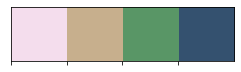

In [18]:
# Plot classification results for metrics of interest

metrics_of_interest = ['AUC', 'balanced_accuracy', 'sensitivity', 'specificity']

scoring = Evaluater()
metric_labels = scoring.evaluate_labels()
metrics_of_interest_indices = [np.where(np.array(metric_labels) == mi)[0][0] for mi in metrics_of_interest]
print(metrics_of_interest_indices)

colors = sns.cubehelix_palette(len(metrics_of_interest), start=0.8, rot=-1.2, light=0.9, dark=0.3)
sns.palplot(colors)

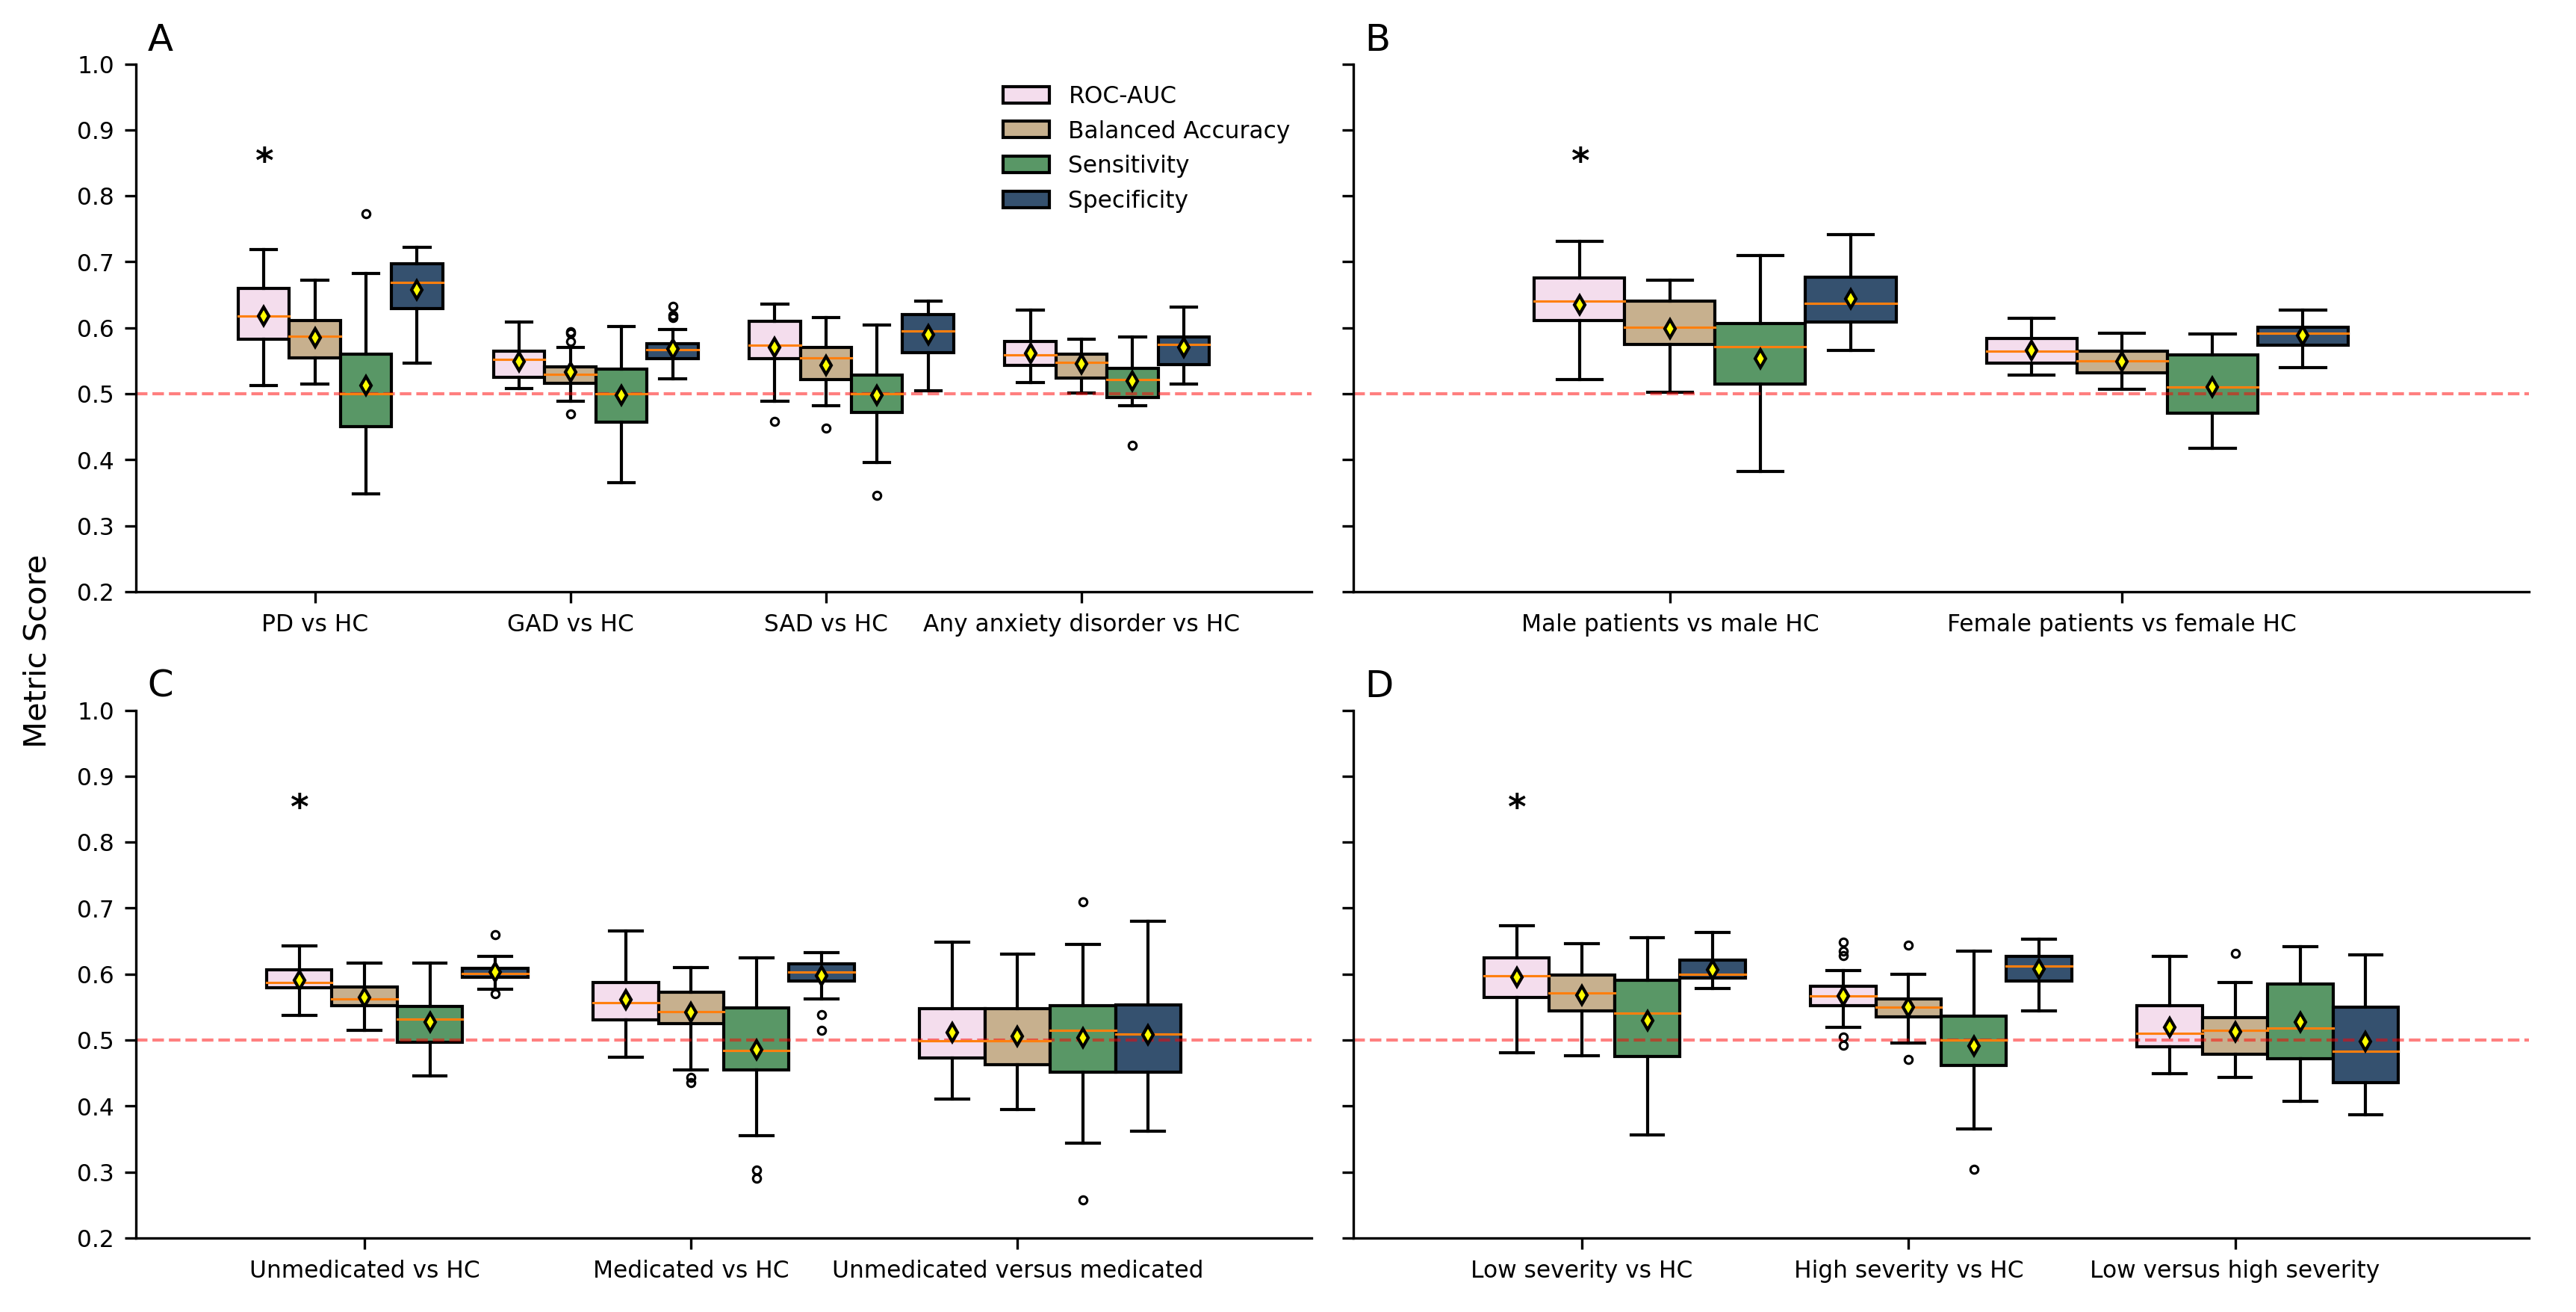

In [19]:
# Create plot with obtained classification performances across four panels

fig_x = 7.48031496 * 1.5 # set width (in inches)
ratio = 1.9
fig_y = fig_x / ratio

fig, axes = plt.subplots(2, 2, sharey=True, figsize=(fig_x, fig_y), dpi=300)

# Plot main classification results
clf_tasks = ['PD', 'GAD', 'SAD', 'cross_disorder']
clf_tasks_labels = ['PD vs HC', 'GAD vs HC', 'SAD vs HC', 'Any anxiety disorder vs HC']
plot_binary_clf_results_on_ax(axes[0, 0], clf_tasks, clf_tasks_labels, 
                              BINARY_CLF_DIR, N_PERMS, outer_cv_folds, outer_cv_repeats)
axes[0, 0].set_title(' A', loc='left', y=0.99)
     
# Plot transdiagnostic results for sex subgroups
clf_tasks = ['cross_disorder_subanalysis_male', 'cross_disorder_subanalysis_female']
clf_tasks_labels = ['Male patients vs male HC', 'Female patients vs female HC']
plot_binary_clf_results_on_ax(axes[0, 1], clf_tasks, clf_tasks_labels, 
                              BINARY_CLF_DIR, N_PERMS, outer_cv_folds, outer_cv_repeats)
axes[0, 1].get_legend().remove()
axes[0, 1].set_title(' B', loc='left', y=0.99)

# Plot transdiagnostic results for medication subgroups
clf_tasks =  ['cross_disorder_subanalysis_unmedicated_pt',
             'cross_disorder_subanalysis_medicated_pt',
             'cross_disorder_subanalysis_unmedicated_vs_medicated']
clf_tasks_labels = ['Unmedicated vs HC', 'Medicated vs HC', 'Unmedicated versus medicated']
plot_binary_clf_results_on_ax(axes[1, 0], clf_tasks, clf_tasks_labels, 
                              BINARY_CLF_DIR, N_PERMS, outer_cv_folds, outer_cv_repeats)
axes[1, 0].get_legend().remove()
axes[1, 0].set_title(' C', loc='left', y=0.99)

# Plot transdiagnostic results for severity subgroups
clf_tasks = ['cross_disorder_subanalysis_low_sev_pt',
             'cross_disorder_subanalysis_high_sev_pt',
             'cross_disorder_subanalysis_low_vs_high_sev']
clf_tasks_labels = ['Low severity vs HC', 'High severity vs HC', 'Low versus high severity']
plot_binary_clf_results_on_ax(axes[1, 1], clf_tasks, clf_tasks_labels, 
                              BINARY_CLF_DIR, N_PERMS, outer_cv_folds, outer_cv_repeats)
axes[1, 1].get_legend().remove()
axes[1, 1].set_title(' D', loc='left', y=0.99)

fig.tight_layout(pad=1.)

# Get extents of subplot
x0 = min([ax.get_position().x0 for ax in axes.ravel()])
y0 = min([ax.get_position().y0 for ax in axes.ravel()])
x1 = max([ax.get_position().x1 for ax in axes.ravel()])
y1 = max([ax.get_position().y1 for ax in axes.ravel()])

# Hidden axes for common x and y labels
plt.axes([x0, y0, x1 - x0, y1 - y0], frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# Add y-label
plt.ylabel("Metric Score")

filename = filename = os.path.join(BINARY_CLF_DIR, 'Figure_3_merged.tiff')
plt.savefig(filename, dpi=300, bbox_inches="tight")